In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [14]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [15]:
missing_data = dataset.isna().sum().sort_values()
missing_data

RID                            0
Gender                         0
Ageatscreening                 0
Diagnosis                      0
HipsSumAveragebaseline         1
MMSE0m                         3
ERCsASMbaseline                4
HipsSumVariancebaseline        7
HipsVariancebaseline           8
ERCsEntropybaseline            9
ERCsSumAveragebaseline        11
ERCsSumVariancebaseline       13
ERCsVariancebaseline          14
HipsContrastbaseline          14
ERCsVolumebaseline            14
ERCsContrastbaseline          18
HipsClusterShadebaseline      18
HipposcampusVolumebaseline    19
HipsCorelationbaseline        20
HipsEntropybaseline           23
HipsASMbaseline               25
ERCsCorelationbaseline        28
ERCsClusterShadebaseline      34
ERCs_thicknessbaseline        37
dtype: int64

In [16]:
# Step 1: split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((425, 23), (183, 23), (425,), (183,))

In [17]:
# Step 2: fill data temp using mean from training set
X_train_filled = X_train.fillna(X_train.mean())
X_test_filled = X_test.fillna(X_test.mean())

# Step 3: normalize features
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train_filled)
X_test_s = scaler.transform(X_test_filled)

# Step 4: add gaussian noise
noise_factor = 0.1
X_train_noise = X_train_s + noise_factor * np.random.normal(loc=0.0, scale=0.1, size=X_train_s.shape)
X_train_noise = np.clip(X_train_noise, 0., 1.)

X_test_noise = X_test_s + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_s.shape)
X_test_noise = np.clip(X_test_noise, 0., 1.)

In [18]:
tf.random.set_seed(42)

def run_denoising_autoencoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    noisy_inputs = layers.GaussianNoise(0.1)(inputs)
    
    # Encoder
    encoded = layers.Dense(126, activation="elu")(noisy_inputs)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(63, activation="elu")(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    
    # Decoder
    decoded = layers.Dense(126, activation="elu")(encoded)
    decoded = layers.Dense(63, activation="elu")(decoded)
    decoded = layers.Dense(input_dim, activation="linear")(decoded)
    
    # Autoencoder model
    autoencoder = models.Model(inputs, decoded)     
    return autoencoder

# Build and compile
input_dim = X_train_s.shape[1]
autoencoder = run_denoising_autoencoder(input_dim)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 23)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_2                │ (None, 23)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 126)            │         3,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 63)             │         8,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 63)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 126)            │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 63)             │         8,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 23)             │         1,472 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,562 (111.57 KB)

 Trainable params: 28,562 (111.57 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = autoencoder.fit(X_train_noise,
                          X_train_s,
                          epochs=50,
                          batch_size=64,
                          validation_split=0.2,
                          verbose=2,
)

Epoch 1/50
6/6 - 5s - 887ms/step - loss: 0.2530 - val_loss: 0.0770
Epoch 2/50
6/6 - 1s - 86ms/step - loss: 0.0992 - val_loss: 0.0481
Epoch 3/50
6/6 - 0s - 54ms/step - loss: 0.0700 - val_loss: 0.0399
Epoch 4/50
6/6 - 1s - 92ms/step - loss: 0.0599 - val_loss: 0.0295
Epoch 5/50
6/6 - 0s - 40ms/step - loss: 0.0467 - val_loss: 0.0269
Epoch 6/50
6/6 - 0s - 40ms/step - loss: 0.0413 - val_loss: 0.0219
Epoch 7/50
6/6 - 0s - 50ms/step - loss: 0.0358 - val_loss: 0.0195
Epoch 8/50
6/6 - 0s - 60ms/step - loss: 0.0326 - val_loss: 0.0180
Epoch 9/50
6/6 - 0s - 40ms/step - loss: 0.0300 - val_loss: 0.0166
Epoch 10/50
6/6 - 0s - 41ms/step - loss: 0.0284 - val_loss: 0.0146
Epoch 11/50
6/6 - 0s - 36ms/step - loss: 0.0266 - val_loss: 0.0145
Epoch 12/50
6/6 - 0s - 34ms/step - loss: 0.0256 - val_loss: 0.0137
Epoch 13/50
6/6 - 0s - 39ms/step - loss: 0.0230 - val_loss: 0.0126
Epoch 14/50
6/6 - 0s - 34ms/step - loss: 0.0228 - val_loss: 0.0124
Epoch 15/50
6/6 - 0s - 37ms/step - loss: 0.0217 - val_loss: 0.0118
Epo

In [20]:
X_test_noise = X_test_s + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_s.shape)
X_test_noise = np.clip(X_test_noise, 0., 1.)

X_train_imputed = autoencoder.predict(X_train_noise)
X_test_imputed = autoencoder.predict(X_test_noise)

X_train_imputed_descaled = scaler.inverse_transform(X_train_imputed)
X_test_imputed_descaled = scaler.inverse_transform(X_test_imputed)

X_train_d = pd.DataFrame(X_train_imputed_descaled, columns=X_train_copy.columns)
X_test_d = pd.DataFrame(X_test_imputed_descaled, columns=X_test_copy.columns)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


### Visualize

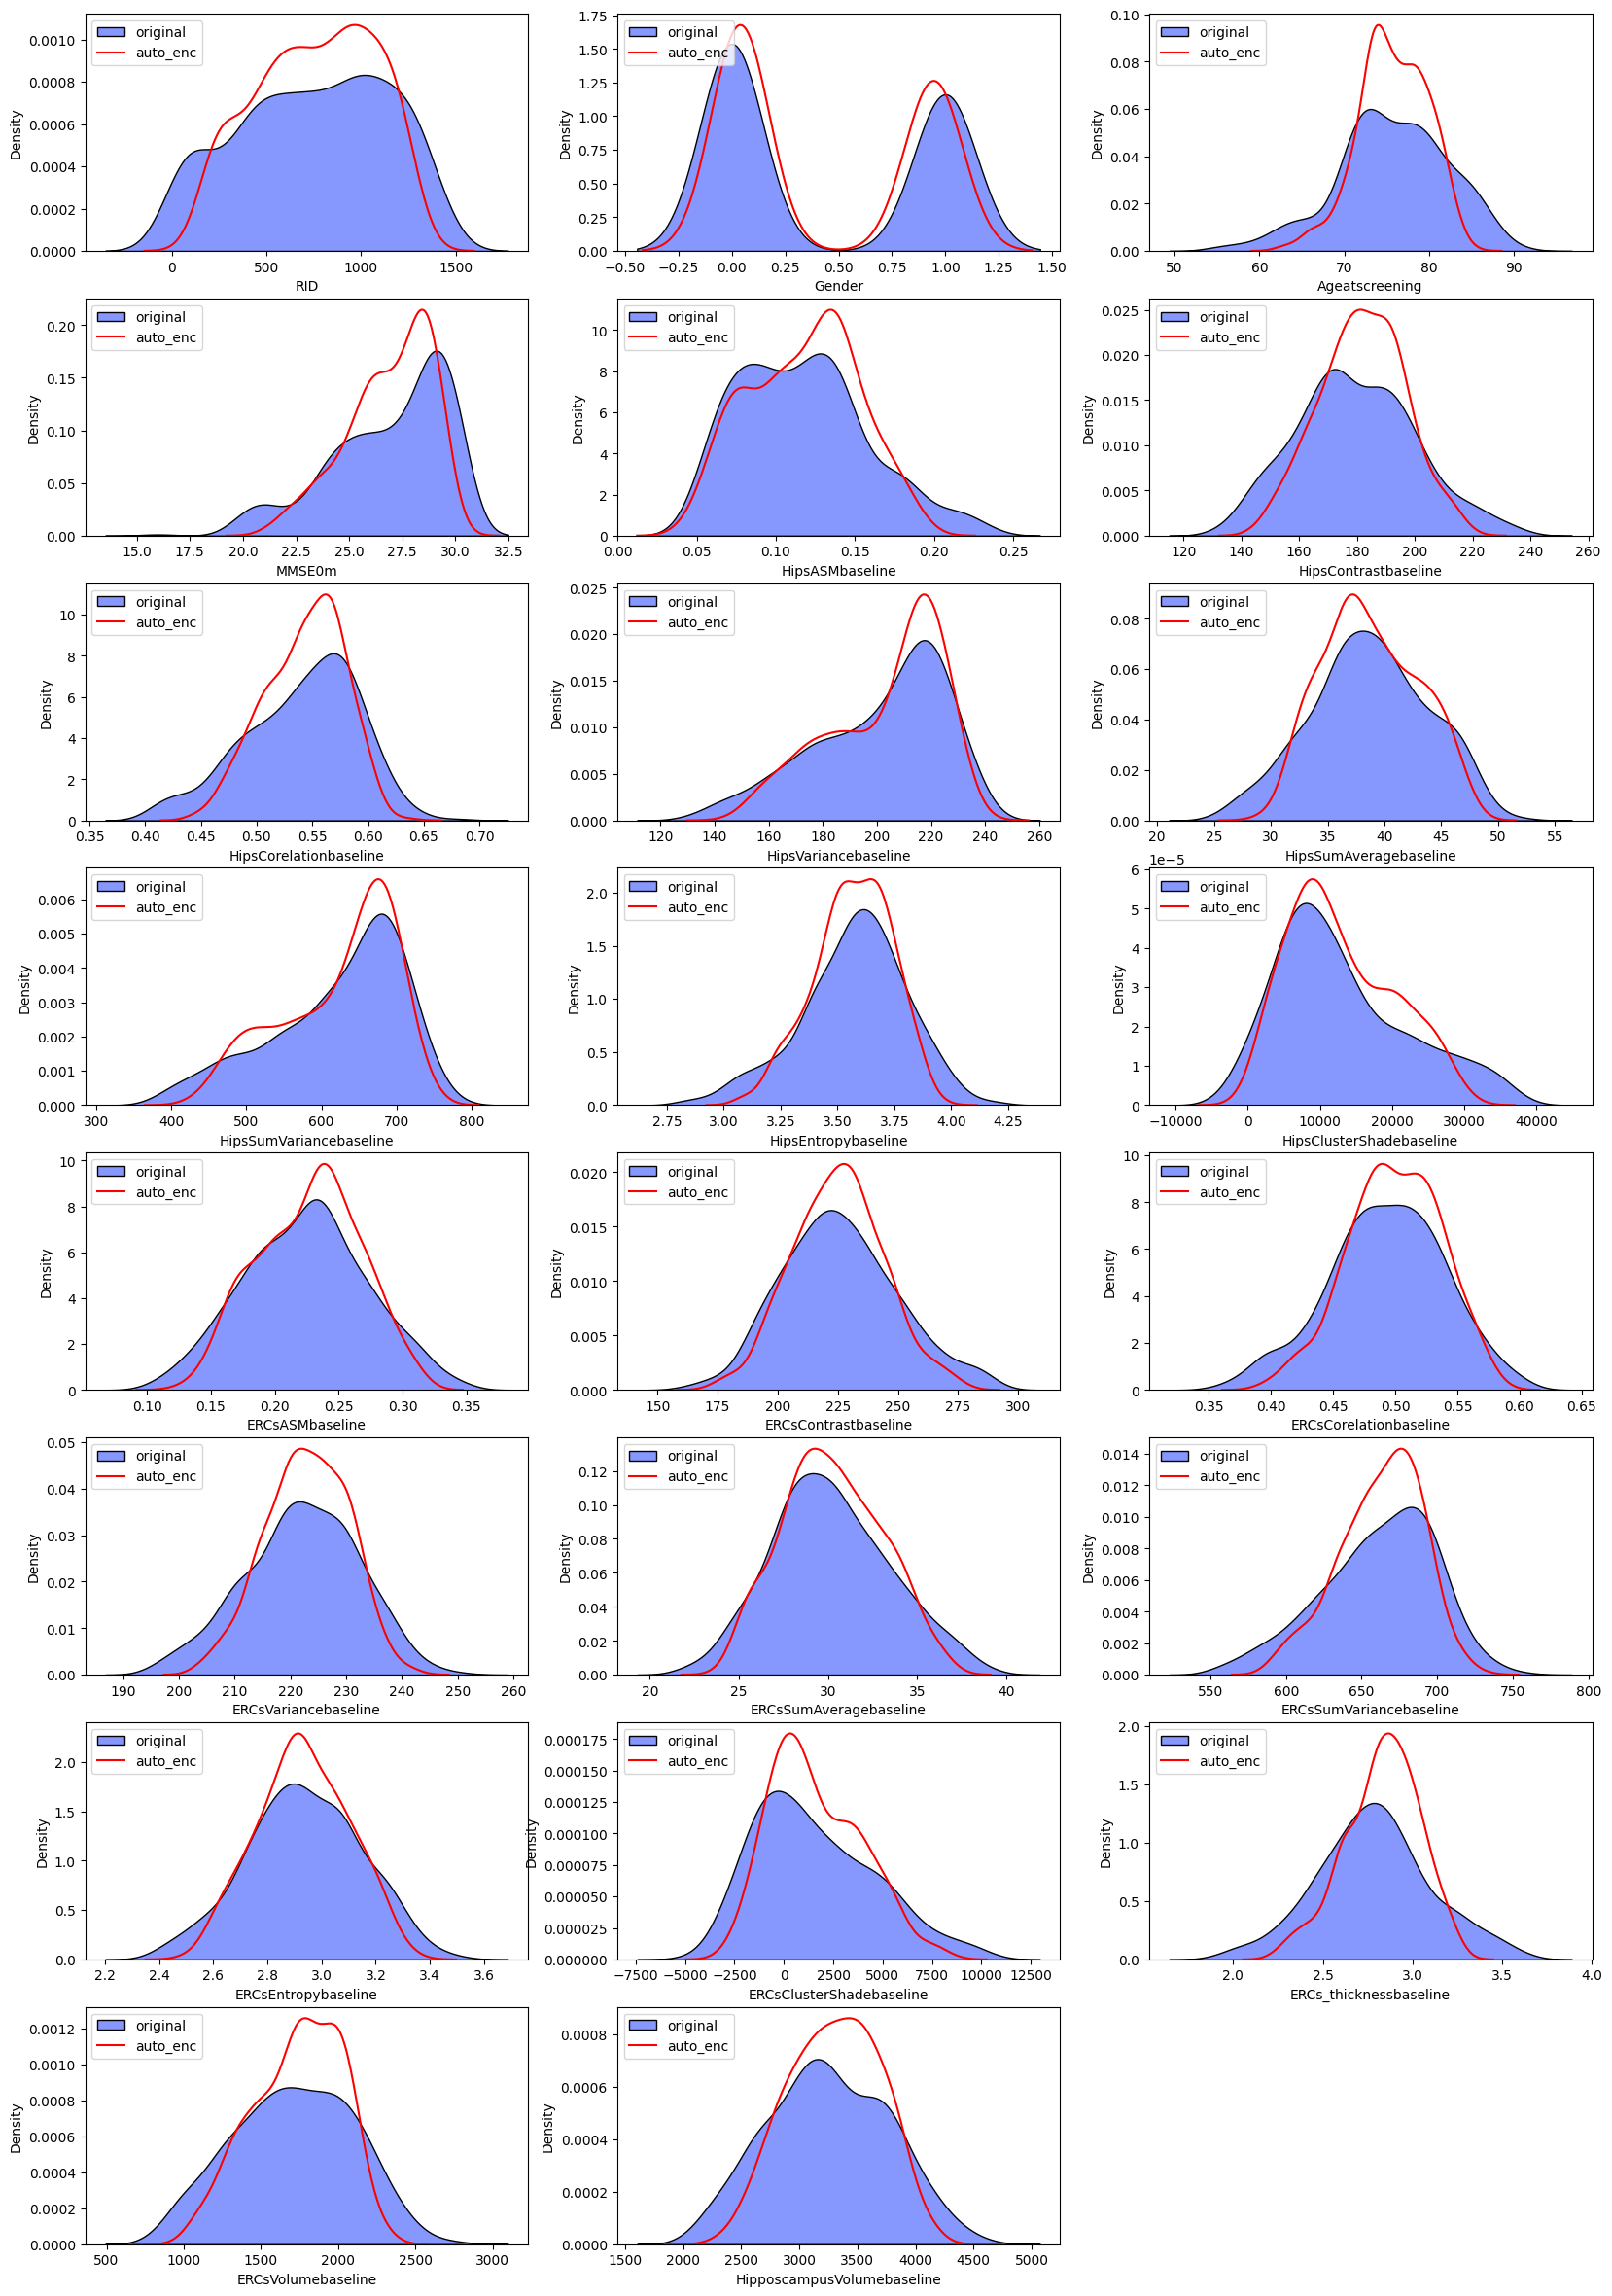

In [21]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_copy[X_train_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_d[X_train_d.columns[i]], color= "red")
    
    labels = ['original', 'auto_enc']
    plt.legend(labels, loc='upper left')

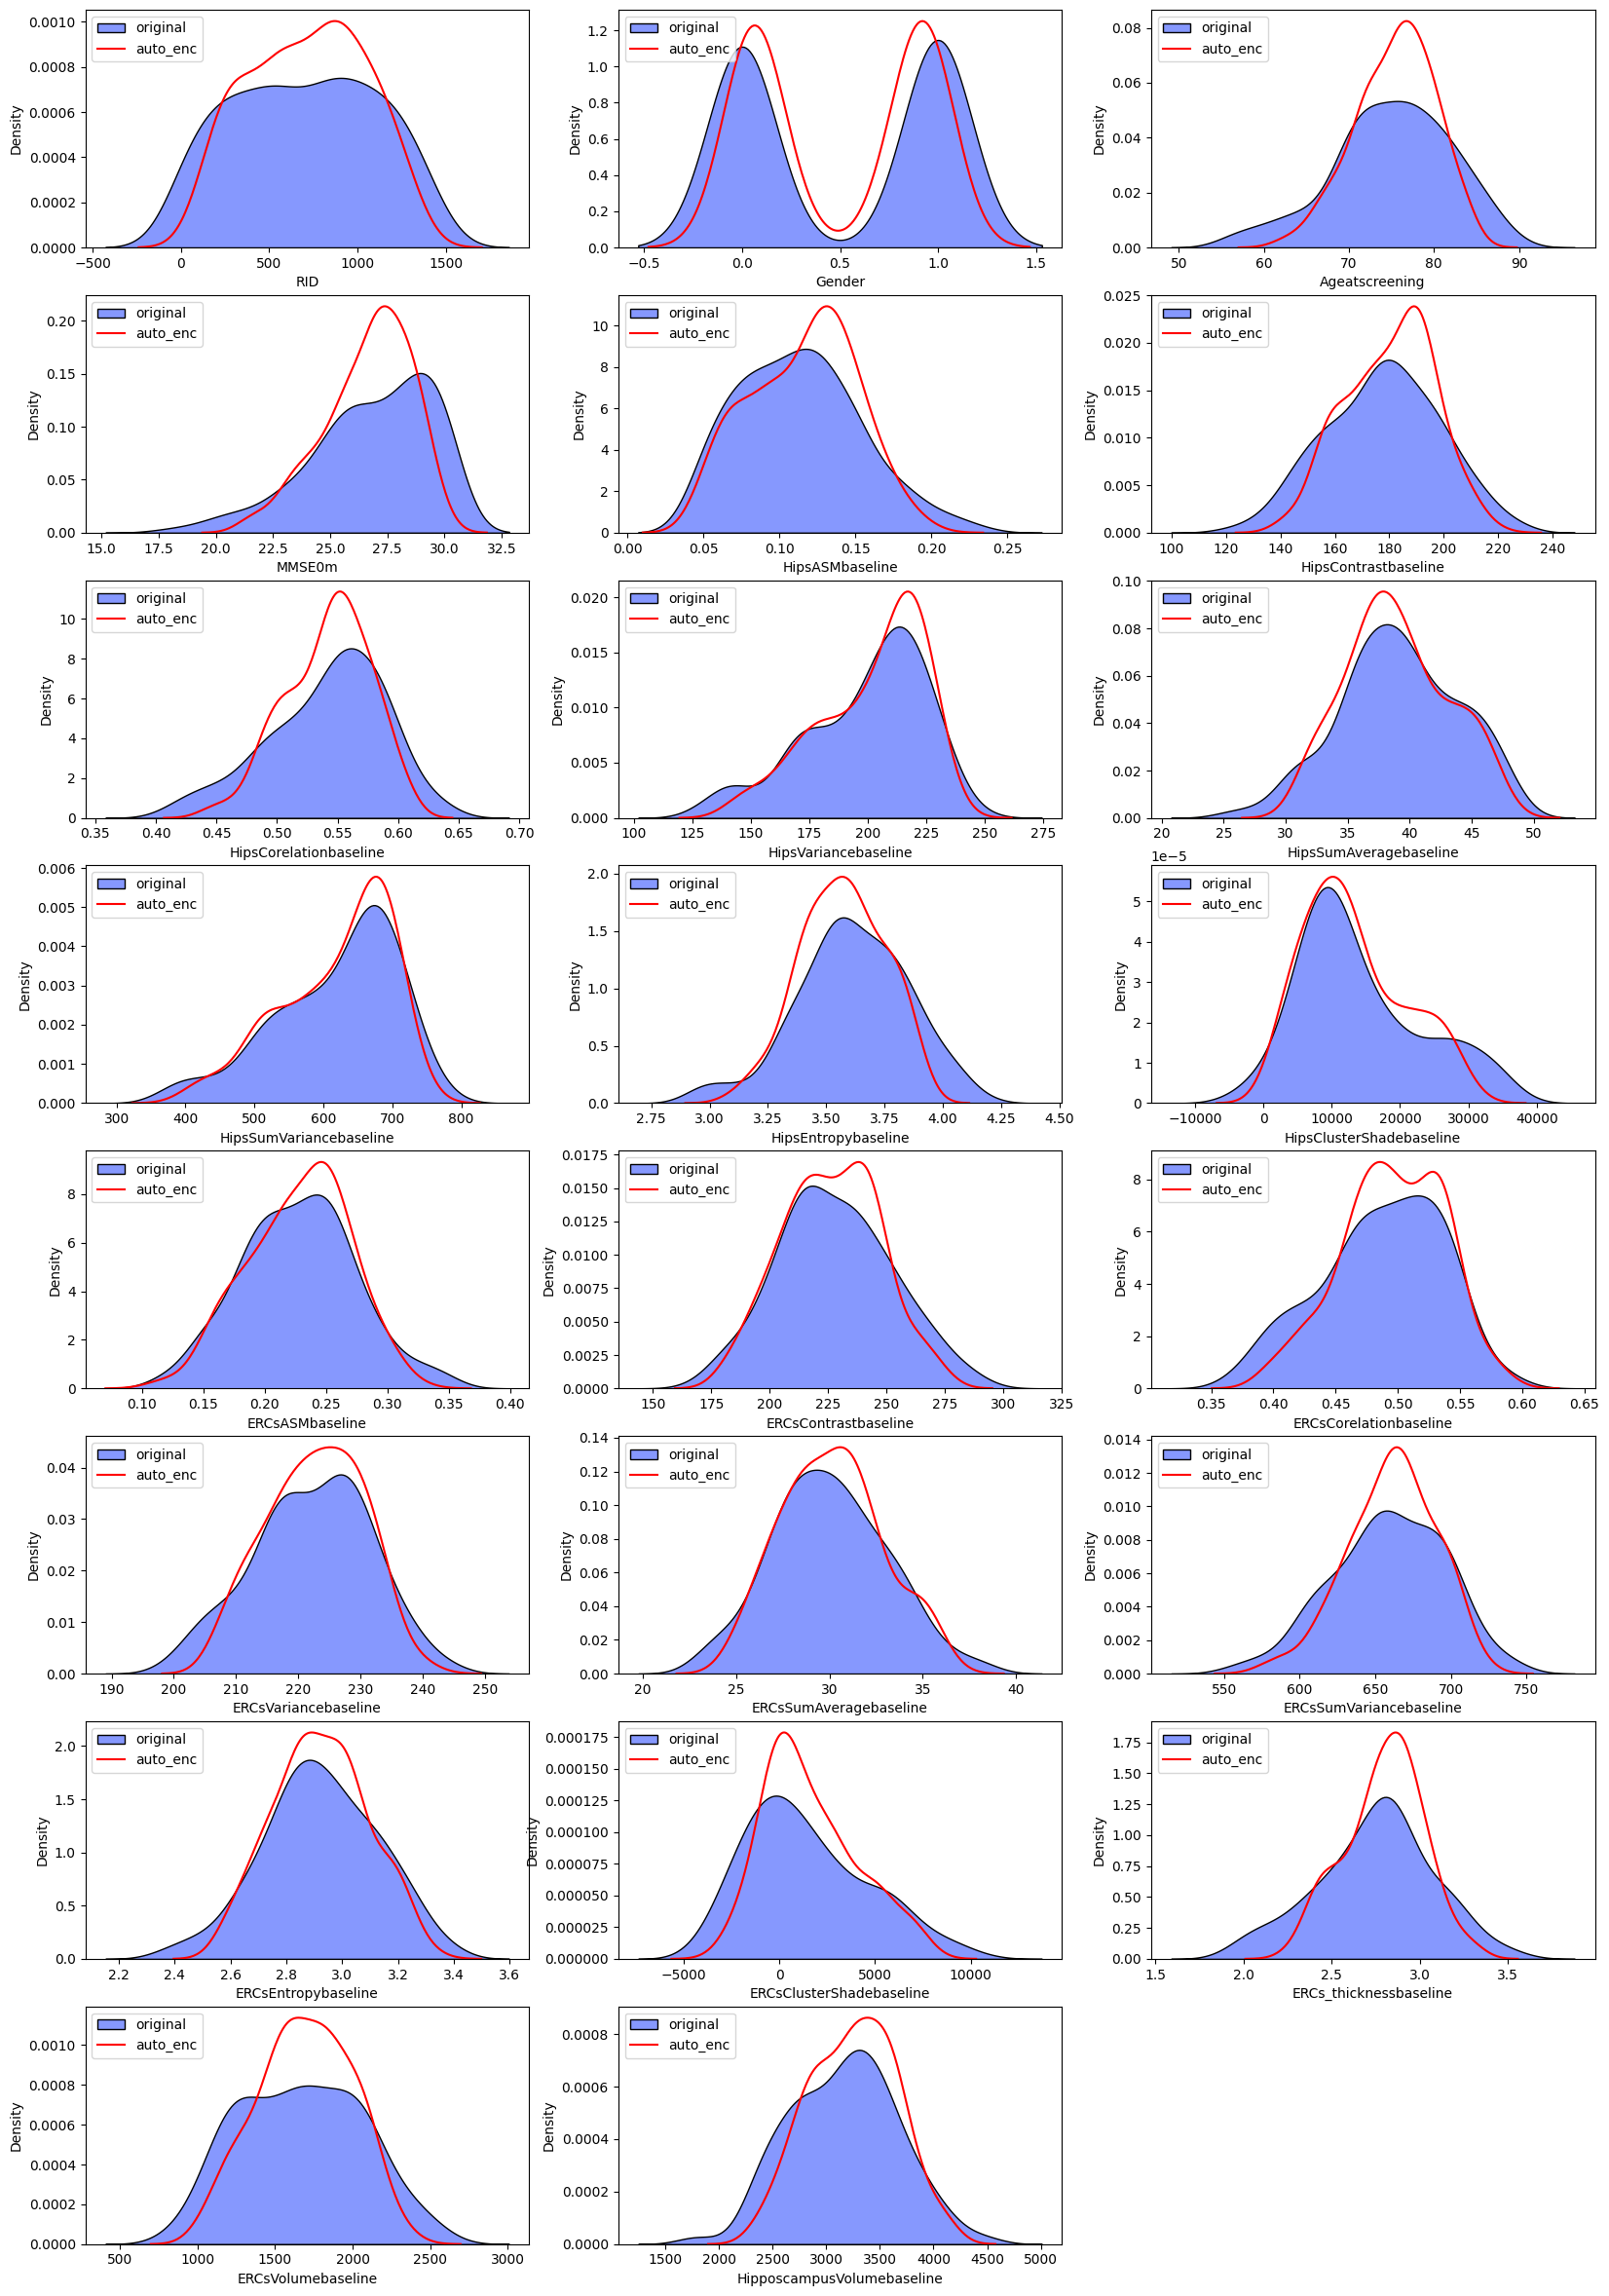

In [22]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_copy[X_test_copy.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_d[X_test_d.columns[i]], color= "red")
    
    labels = ['original', 'auto_enc']
    plt.legend(labels, loc='upper left')

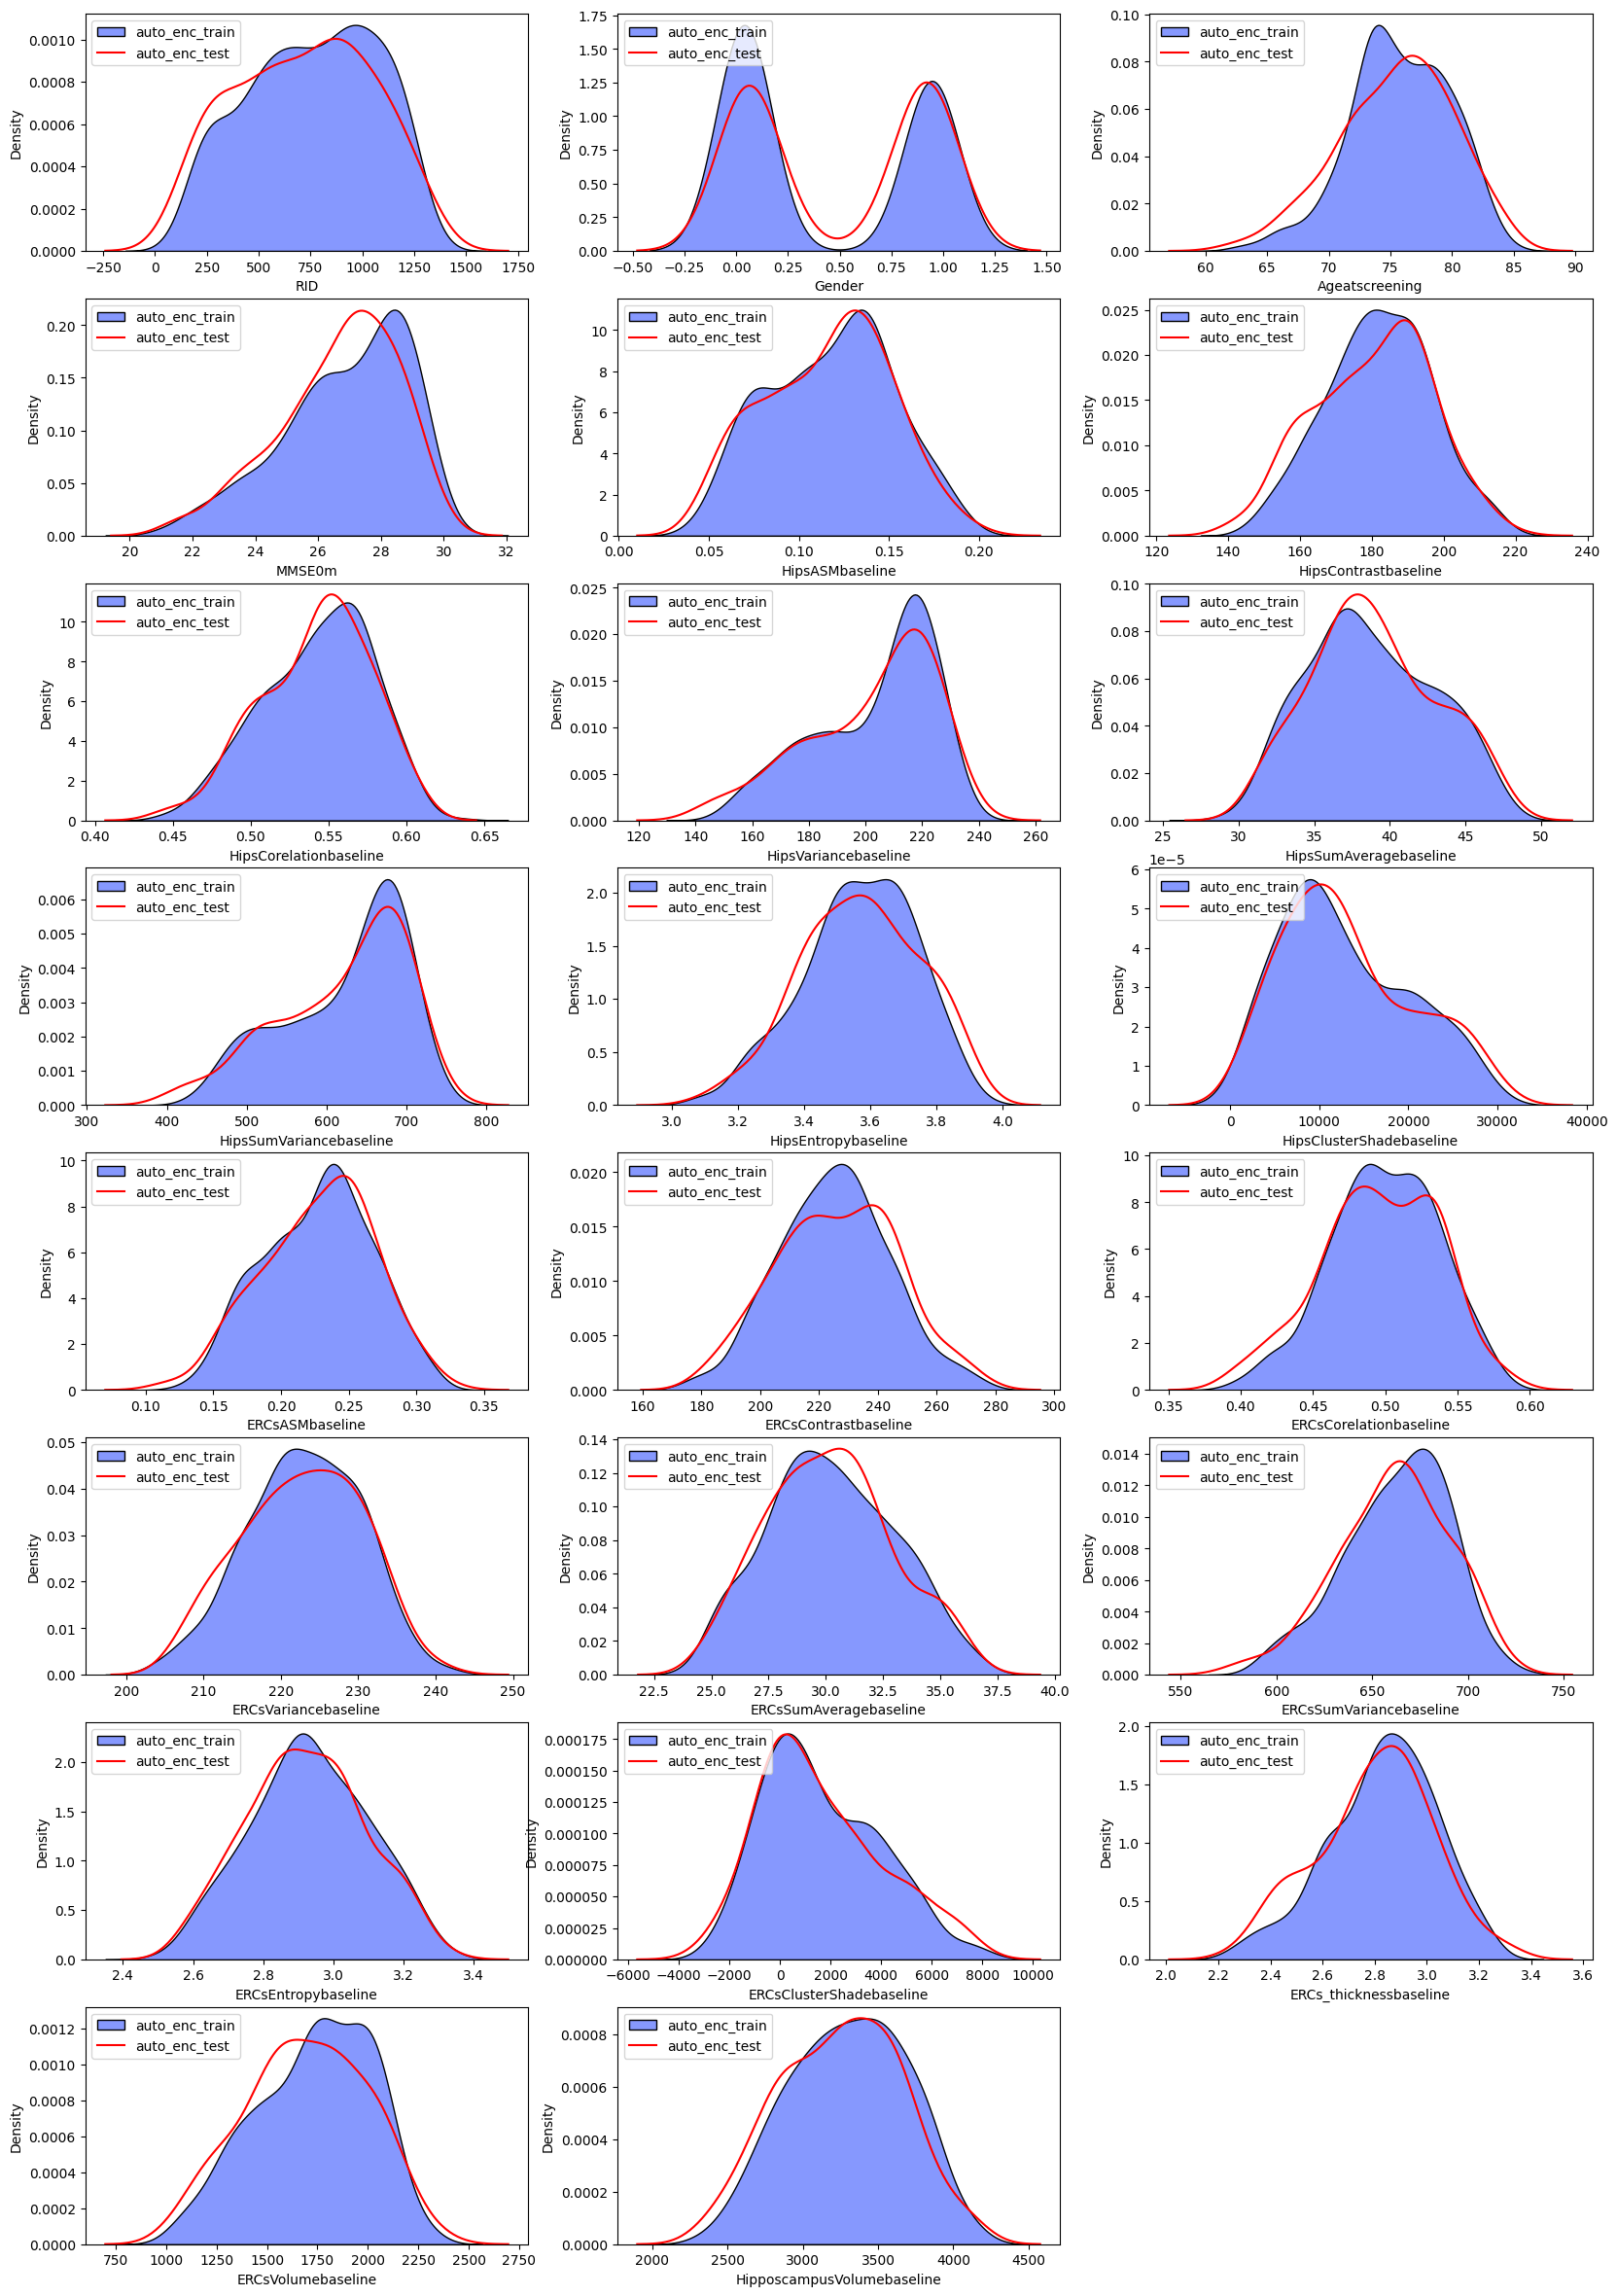

In [23]:
# Plot each column using histograms
plt.figure(figsize=(20, 45))

for i in range(len(X_train_copy.columns)):
    plt.subplot(12,3,i+1)
    sns.kdeplot(X_train_d[X_train_d.columns[i]], color="#5e76fe", multiple="stack")

    plt.subplot(12,3,i+1)
    sns.kdeplot(X_test_d[X_test_d.columns[i]], color= "red")
    
    labels = ['auto_enc_train', 'auto_enc_test']
    plt.legend(labels, loc='upper left')

### Validation Section

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score)

def run_random_forest(X_train, X_test, y_train, y_test):

        # Initialize the Random Forest with class weight balancing
        rf = RandomForestClassifier(n_estimators=100,
                                    max_depth=5,
                                    random_state=42,
                                    class_weight="balanced",
        )
        
        # Fit the model
        rf.fit(X_train, y_train)
        
        # Get predicted probabilities for ROC AUC
        pred_train_proba = rf.predict_proba(X_train)
        pred_test_proba = rf.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train_norm = rf.predict(X_train)
        pred_test_norm = rf.predict(X_test)
        
        # Calculate ROC-AUC
        roc_score_train = roc_auc_score(y_train, 
                                        pred_train_proba, 
                                        average="weighted", 
                                        multi_class="ovr",
        )
        roc_score_test = roc_auc_score(y_test,
                                    pred_test_proba,  
                                    average="weighted", 
                                    multi_class="ovr",
        )
        
        # Calculate accuracies
        accuracy_train = accuracy_score(y_train, pred_train_norm)
        accuracy_test = accuracy_score(y_test, pred_test_norm)
        
        # Print results
        print(f"Train ROC-AUC: {roc_score_train}")
        print(f"Train Accuracy: {accuracy_train}")
        print(f"Test ROC-AUC: {roc_score_test}")
        print(f"Test Accuracy: {accuracy_test}")
        
run_random_forest(X_train_d, X_test_d, y_train, y_test)

Train ROC-AUC: 0.9712002652017668
Train Accuracy: 0.8329411764705882
Test ROC-AUC: 0.7525117478969012
Test Accuracy: 0.5191256830601093
